# Context

After training the model from scratch, we decided it would be better to train a separate model for each phylum. We also opted to use pretrained models. In this notebook, we aim to identify the best-performing pretrained model.

- We compare the models based on their performance on the majority class phylum.
- The same preprocessing steps and model pipeline were used for each model to ensure a fair comparison.


# Imports

In [6]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/rare_species 1.zip'
extract_path = '/content/rare_species 1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, Xception, DenseNet121
from tensorflow.keras.layers import Rescaling, RandAugment

from sklearn.metrics import classification_report

In [8]:
# With colab
folder_path = '/content/rare_species 1/rare_species 1'
meta = pd.read_csv('/content/rare_species 1/rare_species 1/metadata.csv')

# With vscode
# folder_path = '../data/rare_species 1'
# meta = pd.read_csv('../data/rare_species 1/metadata.csv')

# Phylum Splits

This code splits the species into separate folders based on their phylum.  
This organization allows us to train a dedicated model for each phylum more effectively.


# Splits

In [9]:

image_size = (224, 224)
seed = 42
batch_size = 32

train_ds, val_ds= keras.utils.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    subset= "both",
    seed= seed,
    image_size= image_size,
    batch_size= batch_size
)


Found 11983 files belonging to 202 classes.
Using 9587 files for training.
Using 2396 files for validation.


# Defining the different models

In [10]:
# Model creation functions for different architectures
def make_model_vgg16(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained VGG16 base
    base_model = VGG16(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

def make_model_resnet50(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained ResNet50 base
    base_model = ResNet50(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

def make_model_mobilenetv2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained MobileNetV2 base
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

def make_model_xception(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained Xception base
    base_model = Xception(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

def make_model_densenet121(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained DenseNet121 base
    base_model = DenseNet121(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Train and evaluate the models

In [12]:
def train_and_evaluate_model(model, model_name, train_ds, val_ds, epochs=50):
    """Train and evaluate a model, saving the best version"""

    # Learning rate schedule
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )

    # Callbacks
    checkpoint_path = f"best_model_{model_name}.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            save_best_only=True,
            monitor="val_acc",
            mode="max",
            verbose=1
        )
    ]

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

    # Train the model
    history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )

    # Load the best model
    best_model = keras.models.load_model(checkpoint_path)

    # Get predictions
    y_pred_probs = best_model.predict(val_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Get true labels
    y_true = np.concatenate([y for x, y in val_ds], axis=0)

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    report = classification_report(y_true, y_pred, output_dict=True)
    print(classification_report(y_true, y_pred))

    # Return metrics and paths
    return {
        'model_name': model_name,
        'history': history.history,
        'accuracy': report['accuracy'],
        'f1_macro': report['macro avg']['f1-score'],
        'f1_weighted': report['weighted avg']['f1-score'],
        'model_path': checkpoint_path
    }

# Model comparasion


In [13]:
def compare_models(results):
    """Compare results from multiple models"""

    # Create comparison DataFrame
    comparison = pd.DataFrame([
        {'Model': r['model_name'],
         'Accuracy': r['accuracy'],
         'F1 (Macro)': r['f1_macro'],
         'F1 (Weighted)': r['f1_weighted']}
        for r in results
    ])

    # Sort by accuracy
    comparison = comparison.sort_values('Accuracy', ascending=False)

    # Print results
    print(f"\n=== Model Comparison ===")
    print(comparison)

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Plot accuracy comparison
    plt.subplot(1, 2, 1)
    plt.bar(comparison['Model'], comparison['Accuracy'])
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Plot F1 comparison
    plt.subplot(1, 2, 2)
    plt.bar(comparison['Model'], comparison['F1 (Weighted)'])
    plt.title('F1 Score (Weighted) Comparison')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Print best model
    best_model = comparison.iloc[0]
    print(f"\nBest model for: {best_model['Model']}")
    print(f"Accuracy: {best_model['Accuracy']:.4f}")
    print(f"F1 Score (Weighted): {best_model['F1 (Weighted)']:.4f}")

    return comparison

# Function to plot learning curves
def plot_learning_curves(results):
    """Plot learning curves for all models"""

    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for result in results:
        plt.plot(result['history']['acc'], label=f"{result['model_name']} (Train)")
        plt.plot(result['history']['val_acc'], label=f"{result['model_name']} (Val)", linestyle='--')

    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    for result in results:
        plt.plot(result['history']['loss'], label=f"{result['model_name']} (Train)")
        plt.plot(result['history']['val_loss'], label=f"{result['model_name']} (Val)", linestyle='--')

    plt.title(f'Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'learning_curves.png')
    plt.show()

# Model run

<ipython-input-10-9ae534af768a>:48: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")



=== Training VGG16 dataset ===
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - acc: 0.0795 - loss: 6.7769
Epoch 1: val_acc improved from -inf to 0.12270, saving model to best_model_vgg16.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 250s 816ms/step - acc: 0.0796 - loss: 6.7755 - val_acc: 0.1227 - val_loss: 6.4707
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 513ms/step

Classification Report for vgg16:
              precision    recall  f1-score   support

           0       1.00      0.19      0.32        32
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         5
           4       0.60      0.60      0.60         5
           5       0.77      0.47      0.59        51
           6       0.06      0.08      0.07        12
           7       0.00      0.00      0.00         6
           8       1.00      0.29      0.44         7
           9       0.00      0.00      0.00         4
          10       0.67    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - acc: 0.0189 - loss: 22.7542
Epoch 1: val_acc improved from -inf to 0.03756, saving model to best_model_resnet50.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 228s 731ms/step - acc: 0.0190 - loss: 22.7402 - val_acc: 0.0376 - val_loss: 14.1831
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 516ms/step

Classification Report for resnet50:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.04      0.84      0.07        51
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - acc: 0.1831 - loss: 25.4347
Epoch 1: val_acc improved from -inf to 0.37020, saving model to best_model_mobilenetv2.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 201s 647ms/step - acc: 0.1833 - loss: 25.4381 - val_acc: 0.3702 - val_loss: 21.7812
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 497ms/step

Classification Report for mobilenetv2:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        32
           1       1.00      0.20      0.33         5
           2       0.21      0.33      0.26        12
           3       0.75      0.60      0.67         5
           4       0.45      1.00      0.62         5
           5       0.95      0.80      0.87        51
           6       0.27      0.92      0.42        12
           7       0.31      0.83      0.45         6
           8       0.42      0.71      0.53         7
           9       1.00      0.50      0.67         4
          10       1.00      0.40      0.57 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

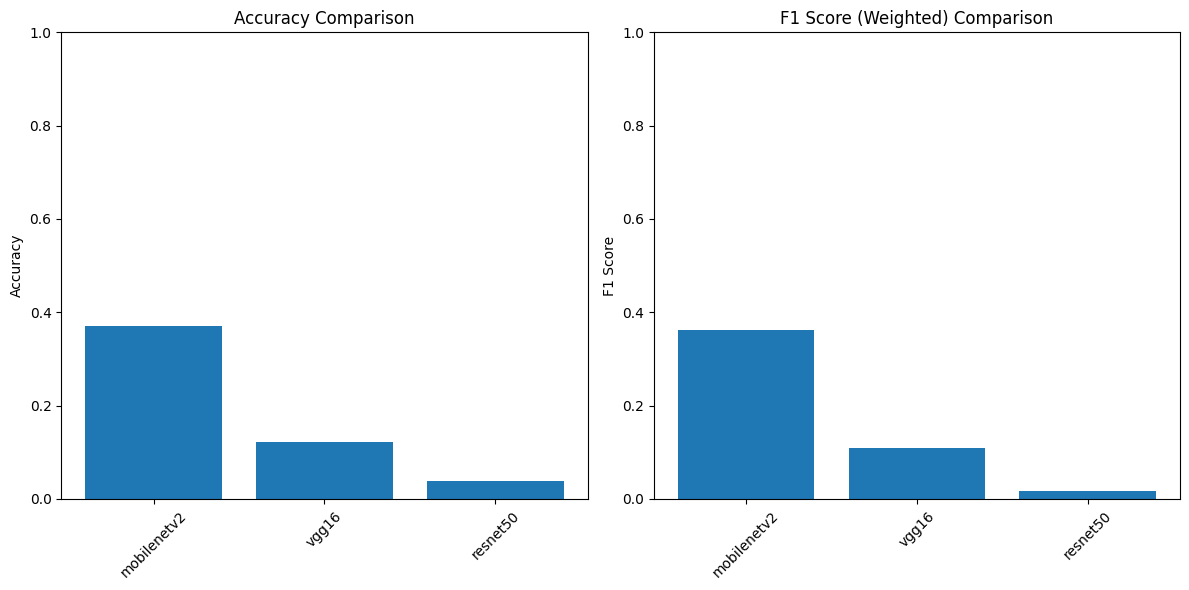


Best model for: mobilenetv2
Accuracy: 0.3702
F1 Score (Weighted): 0.3617


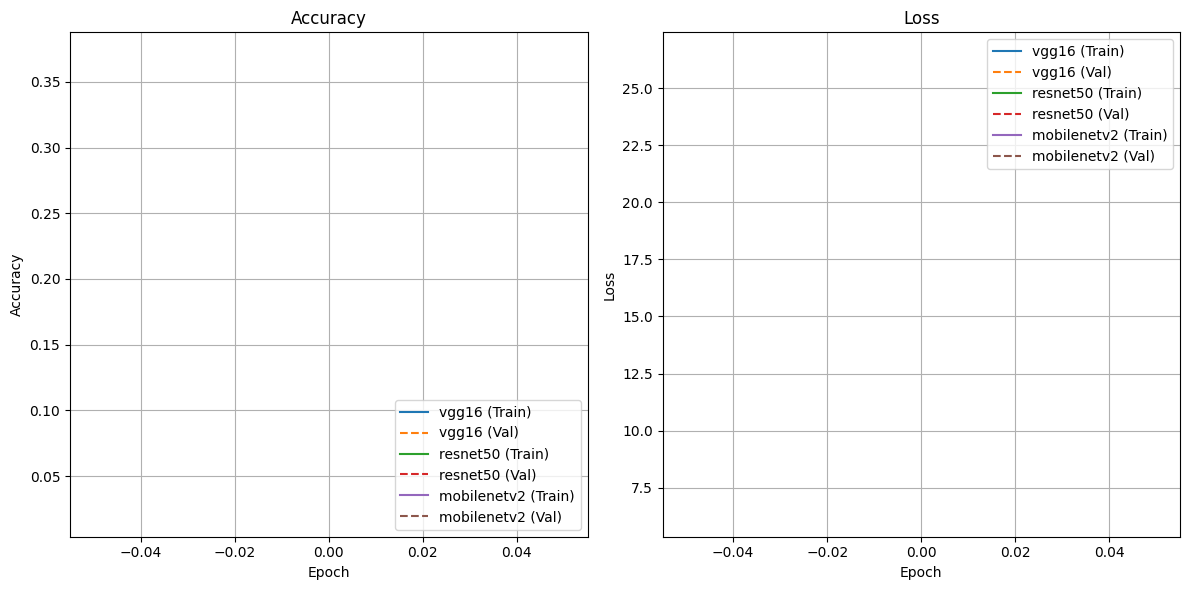

In [16]:
epochs = 20

model_vgg16 = make_model_vgg16(input_shape=image_size + (3,), num_classes=202)
model_resnet50 = make_model_resnet50(input_shape=image_size + (3,), num_classes=202)
model_mobilenet = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=202)

# Train and evaluate models
results = []

# Train VGG16
print("\n=== Training VGG16 dataset ===")
result_vgg16 = train_and_evaluate_model(
    model=model_vgg16,
    model_name="vgg16",
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=epochs
)
results.append(result_vgg16)

# Train ResNet50
print("\n=== Training ResNet50 dataset ===")
result_resnet50 = train_and_evaluate_model(
    model=model_resnet50,
    model_name="resnet50",
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=epochs
)
results.append(result_resnet50)

# Train MobileNetV2
print("\n=== Training MobileNetV2 dataset ===")
result_mobilenet = train_and_evaluate_model(
    model=model_mobilenet,
    model_name="mobilenetv2",
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=epochs
)
results.append(result_mobilenet)

# Compare models
compare_models(results)

# Plot learning curves
plot_learning_curves(results)


# Conclusion